# Previsão de "Churn" para Interconnect
## Objetivo
O objetivo deste projeto é prever a rotatividade (churn) dos clientes da operadora Interconnect. Utilizando dados fornecidos pela equipe de marketing, aplicamos diversas técnicas de machine learning para identificar clientes que estão propensos a cancelar seus serviços.

## Descrição dos Dados
Utilizamos dados de diferentes fontes que cobrem informações contratuais, pessoais e de uso de serviços de telefonia e internet dos clientes. Os principais datasets são:
 
 - `contract.csv`: Informação sobre o contrato de cada cliente.
 - `personal.csv`: Dados pessoais como idade, gênero, etc.
 - `internet.csv`: Informação sobre os serviços de internet utilizados.
 - `phone.csv`: Informação sobre os serviços de telefonia utilizados.

## Métricas de Avaliação
- Métrica primária: AUC-ROC
- Métrica adicional: Acurácia

Etapas do Projeto:
1. **Carregamento e inspeção dos dados**: Analisaremos os dados de cada fonte e faremos o pré-processamento necessário.
2. **Exploração e visualização dos dados**: Visualizaremos os padrões importantes para entender o comportamento dos clientes.
3. **Tratamento de anomalias**: Identificamos e removemos anomalias nos dados, como valores fora do esperado.
4. **Engenharia de características**: Convertendo colunas categóricas em numéricas para permitir o uso em algoritmos de machine learning.
5. **Treinamento de modelos**: Testaremos diversos algoritmos, incluindo Random Forest, LightGBM, KNN, CatBoost, e outros.
6. **Avaliação de performance**: Vamos comparar a performance dos modelos usando métricas como AUC-ROC, F1-Score e acurácia.
7. **Seleção de modelo**: Selecionar o modelo com a melhor combinação de AUC-ROC e acurácia, sendo escolhido como modelo final.


# Inicialização

In [1]:
# Bibliotecas padrão
import time
import regex as re
# Manipulação de dados
import pandas as pd
import numpy as np
# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from pyod.models.knn import KNN
# Pré-processamento de dados
from sklearn.preprocessing import LabelEncoder
# Avaliação de modelos
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, make_scorer
import shap
# Divisão e validação dos dados
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Pré customização dos graficos
plt.rcParams['figure.figsize'] = [14, 5] # Tamanho padrão da figura
plt.rcParams['font.size'] = 12 # Tamanho padrão da fonte

# Paleta de cores com degradê de até 10 cores
colors = sns.color_palette("coolwarm", 10)
sns.set_palette(colors)
plt.style.use('ggplot')

# Fonte da legenda e títulos dos eixos mais clara
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

plt.rcParams['legend.fontsize'] = 12 # Tamanho da legenda
plt.rcParams['lines.linewidth'] = 2

# Alterar largura das linhas para torná-las mais visíveis
plt.rcParams['lines.linewidth'] = 2

# Recebendo os dados

In [3]:
df_contract  = pd.read_csv("final_provider/contract.csv")
df_personal = pd.read_csv("final_provider/personal.csv")
df_internet = pd.read_csv("final_provider/internet.csv")
df_phone = pd.read_csv("final_provider/phone.csv")

# Ferramentas

In [4]:
def identify_anomaly(column, result_view=False, weight=0.25):
    """ Retorna o calculo de anormalidades a partir dos quartis (Q1, Q3) """
    column = column.dropna()  # remove nulls se ainda tiver
    if column.dtypes == 'int64' or column.dtypes == 'int32' or column.dtypes == 'float':  # filtra só por numéricos
        plt.figure()  # cria uma nova figura para o gráfico
        boxplot = plt.boxplot(column.values)
        plt.title(f"Boxplot da coluna {column.name}")
        
        outliers = list(boxplot['fliers'][0].get_data()[1])
        print(f'Valores atípicos na coluna {column.name}:', len(outliers))
        
        min_val = column.min()
        max_val = column.max()
        Q1 = column.quantile(weight)
        Q3 = column.quantile(1-weight)
        IQR = Q3 - Q1 
        Q1 = Q1 - 1.5 * IQR    
        Q3 = Q3 + 1.5 * IQR

        if result_view:
            print(f"Coluna: {column.name}")
            print(f"\033[91m Menor {min_val}, Anormal: {Q1} \033[30m") if min_val < Q1 else print(f"\033[32m Menor {min_val}, Anormal: {Q1} \033[30m") 
            print(f"\033[91m Maior {max_val}, Anormal: {Q3} \033[30m") if max_val > Q3 else print(f"\033[32m Maior {max_val}, Anormal: {Q3} \033[30m") 
            print(f"IQR: {IQR}")
            print()
            if min_val > Q1 and max_val < Q3:
                return None
        return Q1, Q3
    
    else:
        if result_view:
            print(column.name, "Não é numérico")
        return None

In [5]:
def clean_over(dataframe, weight=0.25, show_results=False):
    """ Cria uma query para remover todos os anormais de todas colunas do dataframe """
    query = ""
    for column in dataframe.columns:
        result = identify_anomaly(dataframe[column].dropna(), show_results, weight=weight)

        # Verificar se o resultado não é None (none != numeric)
        if result is not None:
            min, max = result # pega o minimo e o maximo da coluna
            query += f'({min} < `{column}`) and ( `{column}` < {max} ) and '

    return query[:-4]

In [6]:
def name_reformat(text):
    """ reparo individual """
    
    new_text = re.sub(r'([a-z])([A-Z])', r'\1_\2', text).lower()

    return new_text[0].lstrip('_') + new_text[1:]
def list_name_reformat(names):
    """ reparo de lista """
    new_names = []
    for name in names:
        new_names.append(name_reformat(name))
    return new_names


In [7]:
class Metodo_avaliativo:
    def __init__(self):
        self.ranking_model = {}
        self.target_score = 75

    def add_model(self, model, target_test, features_test, time_lapse=0):
        """
        Adiciona um modelo ao ranking e calcula as métricas: ROC AUC, F1-Score, e Acurácia.
        :param model_name: Nome do modelo
        :param target_test: Valores reais do conjunto de teste
        :param predictions: Previsões feitas pelo modelo
        :param time_lapse: Tempo de execução do modelo
        :param proba_predictions: Probabilidades previstas (necessárias para calcular o ROC AUC)
        """
        model_name = type(model).__name__
        predictions = model.predict(features_test)
        try:
            proba_predictions = model.predict_proba(features_test)[:, 1]
        except:
            proba_predictions = None
        # Calcular as métricas principais
        accuracy = accuracy_score(target_test, predictions)
        f1 = f1_score(target_test, predictions)
        
        # Verificar se as probabilidades foram fornecidas para calcular ROC AUC
        roc_auc = None
        if proba_predictions is not None:
            roc_auc = roc_auc_score(target_test, proba_predictions)

        # Exibir as métricas
        print(f" Acurácia: {accuracy}")
        print(f" F1-Score: {f1}")
        if roc_auc is not None:
            print(f" ROC AUC: {roc_auc}")
        print(f"Tempo total de execução: {time_lapse:.2f} segundos")
        
        # Armazenar as métricas no ranking
        self.ranking_model[model_name] = [round(accuracy, 4)*100, round(f1, 4)*100, round(roc_auc, 4)*100, time_lapse]
        
        # Plotar as métricas em gráficos da curva ROC e matriz de confusão
        self.plot_metrics_roc_confusion_matrix(model_name, accuracy, f1, roc_auc, target_test, predictions, proba_predictions)
        
        
    def get_ranking(self, sort_by="ROC_AUC", ascending=False):
        """
        Retorna um DataFrame com o ranking dos modelos de acordo com a métrica especificada.
        :param sort_by: Métrica pela qual o ranking será ordenado (ex: Acurácia, F1-Score, ROC AUC)
        :param ascending: Ordenar de forma ascendente ou descendente
        :return: DataFrame com o ranking dos modelos
        """
        df = (pd.DataFrame(self.ranking_model, index=['Acurácia', "F1-Score", "ROC_AUC", "Tempo_de_execução"])).T
        return df.sort_values(ascending=ascending, by=sort_by)

    def plot_metrics_roc_confusion_matrix(self, model_name, accuracy, f1, roc_auc, target_test, predictions, proba_predictions):
        """
        Plota as métricas de Acurácia, F1-Score e ROC AUC, juntamente com a curva ROC e a matriz de confusão.
        :param model_name: Nome do modelo
        :param accuracy: Acurácia do modelo
        :param f1: F1-Score do modelo
        :param roc_auc: ROC AUC do modelo
        :param target_test: Valores reais do conjunto de teste
        :param predictions: Previsões feitas pelo modelo
        :param proba_predictions: Probabilidades previstas pelo modelo
        """
        metrics = ['Acurácia', 'F1-Score', 'ROC AUC']
        values = [accuracy, f1, roc_auc if roc_auc is not None else 0]

        # Gráfico de métricas, Curva ROC, Matriz de Confusão
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Subplot 1: Gráficos de barra para Acurácia, F1-Score, ROC AUC
        axes[0].bar(metrics, values, color=['blue', 'green', 'orange'])
        axes[0].set_title(f'Métricas - {model_name}')
        axes[0].set_ylim(0, 1)
        axes[0].set_ylabel('Valor')

        # Subplot 2: Curva ROC
        if proba_predictions is not None:
            fpr, tpr, _ = roc_curve(target_test, proba_predictions)
            axes[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
            axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')
            axes[1].set_xlim([0.0, 1.0])
            axes[1].set_ylim([0.0, 1.05])
            axes[1].set_xlabel('False Positive Rate')
            axes[1].set_ylabel('True Positive Rate')
            axes[1].set_title(f'Curva ROC - {model_name}')
            axes[1].legend(loc="lower right")
            axes[1].grid(True)

        # Subplot 3: Matriz de Confusão
        conf_matrix = confusion_matrix(target_test, predictions)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
        axes[2].set_title(f'Matriz de Confusão - {model_name}')
        axes[2].set_xlabel('Predito')
        axes[2].set_ylabel('Real')
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


ranking = Metodo_avaliativo()

# Pré analise dos dados

## Dados no `contract`

In [8]:
def sum_total_days(df):
    """ adiciona a coluna com o total de dias que os usuarios perduraram """
    begin = df['BeginDate']
    end = df['EndDate']
    try:
        if end != "No":
            result = pd.to_datetime(end, format='%Y-%m-%d') - pd.to_datetime(begin, format='%Y-%m-%d')
        else:
            result = pd.to_datetime('2020-02-01', format='%Y-%m-%d') - pd.to_datetime(begin, format='%Y-%m-%d')
    except Exception as e:
        print("ERROR:",e, begin, end)
        
    return result

In [9]:
df_contract['endure'] = df_contract.apply(sum_total_days, axis=1)

In [10]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,endure
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,31 days
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,61 days
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1371 days
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,61 days


Primeira impressão, já possuimos uma coluna com dados boleanos e datetime

In [11]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        7043 non-null   object         
 1   BeginDate         7043 non-null   object         
 2   EndDate           7043 non-null   object         
 3   Type              7043 non-null   object         
 4   PaperlessBilling  7043 non-null   object         
 5   PaymentMethod     7043 non-null   object         
 6   MonthlyCharges    7043 non-null   float64        
 7   TotalCharges      7043 non-null   object         
 8   endure            7043 non-null   timedelta64[ns]
dtypes: float64(1), object(7), timedelta64[ns](1)
memory usage: 495.3+ KB


Quase tudo como object, totalCharges deverá estar como float

In [12]:
df_contract.describe()

,MonthlyCharges,endure
count,7043.000000,7043
mean,64.761692,985 days 23:54:28.777509568
std,30.090047,747 days 14:06:29.712340960
min,18.250000,0 days 00:00:00
25%,35.500000,273 days 00:00:00
50%,70.350000,883 days 00:00:00
75%,89.850000,1676 days 00:00:00
max,118.750000,2191 days 00:00:00


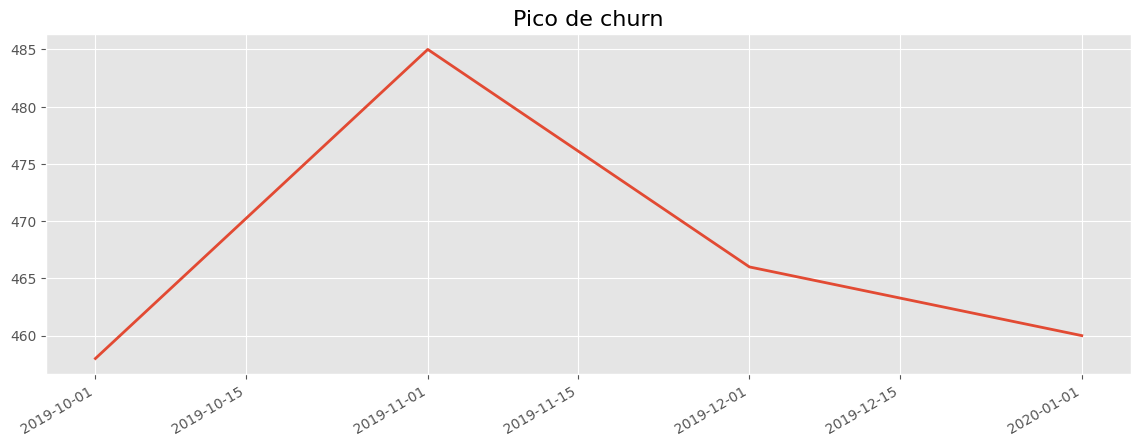

In [13]:
# analise do maior pico "churn"
pd.to_datetime(df_contract.query('EndDate != "No"')['EndDate'], format='%Y-%m-%d').value_counts().plot()
plt.title("Pico de churn")
plt.show()

## Dados em `personal`

In [14]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


mais colunas dispostas em object envez de int ou boolean, contudo não mudarei pois pretendo converte-las em classificação

In [16]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


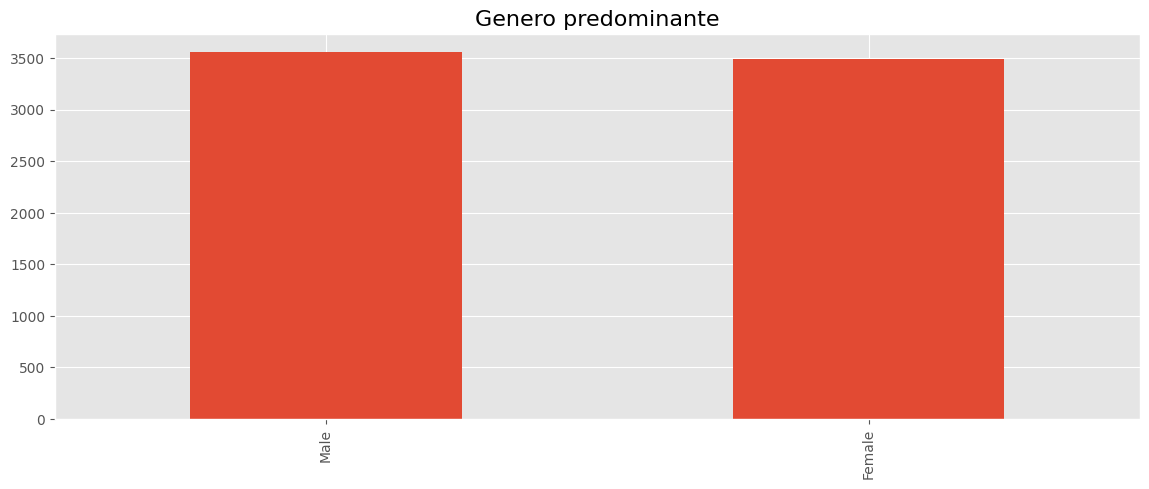

In [17]:
df_personal['gender'].value_counts().plot(kind='bar')
plt.title("Genero predominante")
plt.show()

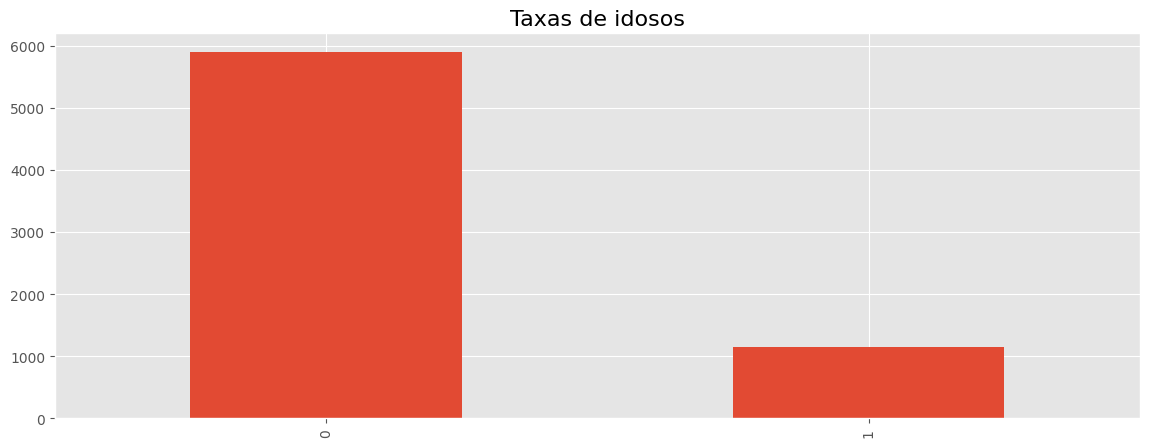

In [18]:
df_personal['SeniorCitizen'].value_counts().plot(kind='bar')
plt.title('Taxas de idosos')
plt.show()

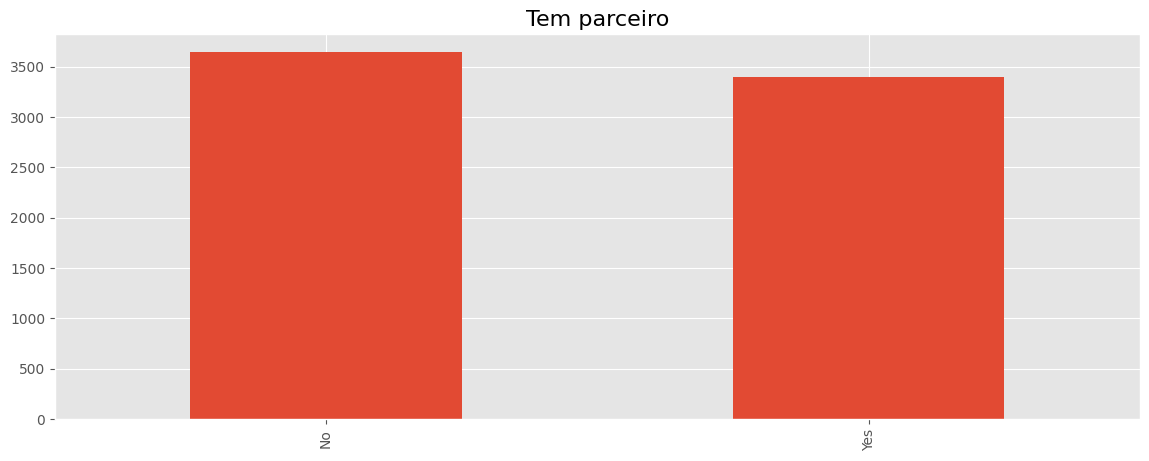

In [19]:
df_personal['Partner'].value_counts().plot(kind='bar')
plt.title('Tem parceiro')
plt.show()

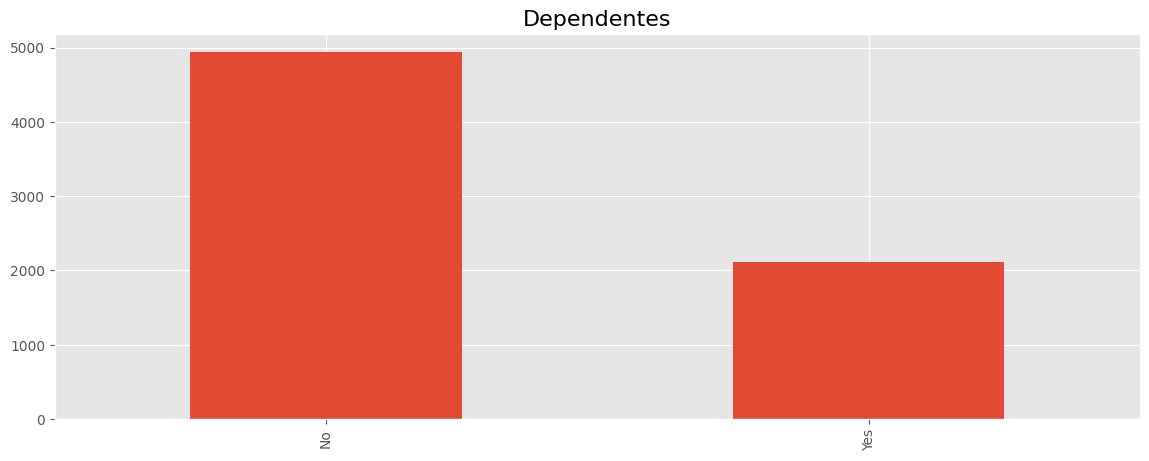

In [20]:
df_personal['Dependents'].value_counts().plot(kind='bar')
plt.title("Dependentes")
plt.show()

A Maioria dos clientes não possuem dependentes

## Dados em `Internet`

In [21]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [22]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


varios dados booleanos estão como strings

In [23]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


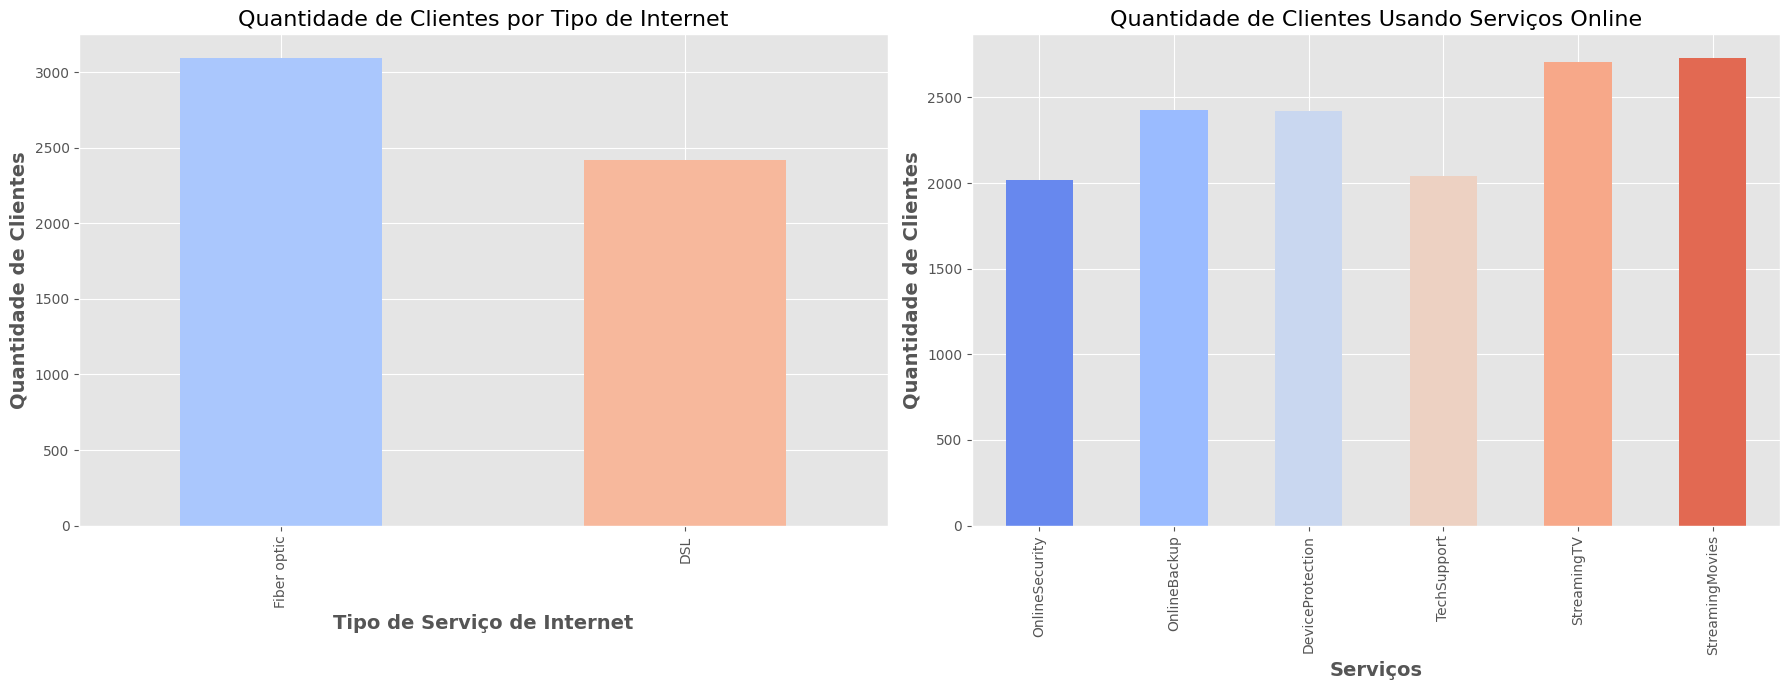

In [24]:
# Configurar o layout com dois gráficos lado a lado (esquerda e direita)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Contagem de tipos de InternetService
internet_service_counts = df_internet['InternetService'].value_counts()
internet_service_counts.plot(kind='bar', ax=axes[0], color=sns.color_palette("coolwarm", 2))
axes[0].set_title('Quantidade de Clientes por Tipo de Internet', fontsize=16)
axes[0].set_xlabel('Tipo de Serviço de Internet', fontsize=14)
axes[0].set_ylabel('Quantidade de Clientes', fontsize=14)

# Gráfico 2: Contagem de serviços online
service_counts = df_internet.drop(['customerID','InternetService'], axis=1).apply(lambda x: x.value_counts().get('Yes', 0))
service_counts.plot(kind='bar', ax=axes[1], color=sns.color_palette("coolwarm", len(service_counts)))
axes[1].set_title('Quantidade de Clientes Usando Serviços Online', fontsize=16)
axes[1].set_xlabel('Serviços', fontsize=14)
axes[1].set_ylabel('Quantidade de Clientes', fontsize=14)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

Uma grande quantidade de usuarios são favoraveis aos streamings e intenet de fibra otica

## Dados em `phone`

In [25]:
# preview dos dados
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [26]:
# formato dos dados
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


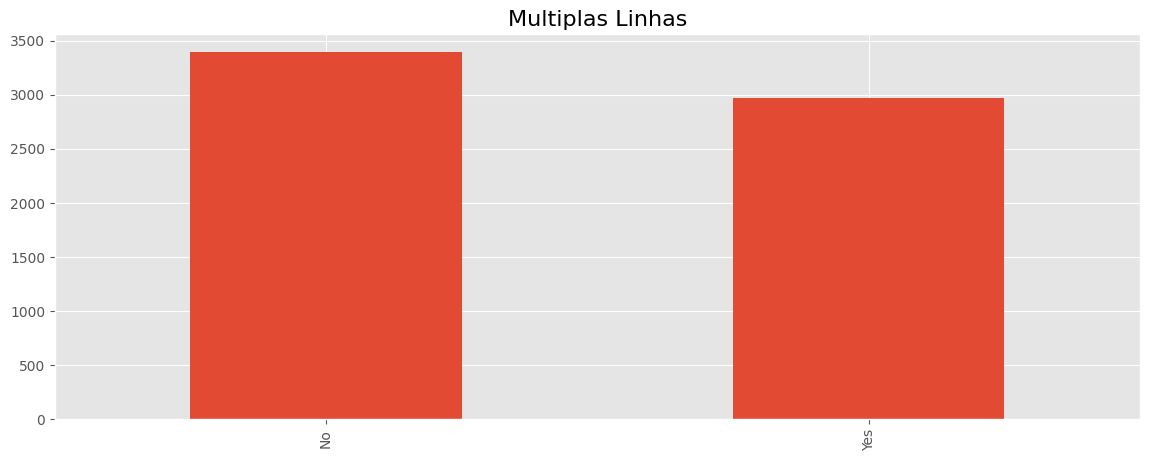

In [27]:
df_phone['MultipleLines'].value_counts().plot(kind='bar')
plt.title("Multiplas Linhas")
plt.show()

boa parte dos clientes não usam mais de uma linha

# Junção de todos os dataframes

afim de referenciar os usarios que sofreram ou não o 'churn'

In [28]:
df_result = pd.merge(df_contract, df_personal, on='customerID', how='inner')
df_result = pd.merge(df_result, df_internet, on='customerID', how='outer')
df_result = pd.merge(df_result, df_phone, on='customerID', how='outer')

In [29]:
# renomeia as colunas para melhor leitura
df_result.columns = list_name_reformat(df_result.columns)

In [30]:
# result
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   customer_id        7043 non-null   object         
 1   begin_date         7043 non-null   object         
 2   end_date           7043 non-null   object         
 3   type               7043 non-null   object         
 4   paperless_billing  7043 non-null   object         
 5   payment_method     7043 non-null   object         
 6   monthly_charges    7043 non-null   float64        
 7   total_charges      7043 non-null   object         
 8   endure             7043 non-null   timedelta64[ns]
 9   gender             7043 non-null   object         
 10  senior_citizen     7043 non-null   int64          
 11  partner            7043 non-null   object         
 12  dependents         7043 non-null   object         
 13  internet_service   5517 non-null   object       

## tratamento dos dados em conjunto

In [31]:
# coluna datetime
df_result['begin_date'] = pd.to_datetime(df_result['begin_date'], format='%Y-%m-%d')

In [32]:
# vou manter a coluna como objetct porem com valores boleanos, pois categorizarei posteriormente
df_result.loc[df_result['end_date'] != "No", 'end_date'] = "Yes"

In [33]:
# vou renomear a coluna de end_date para churn pois não há mais datas nessa coluna
df_result.rename({'end_date':'churn'}, axis=1, inplace=True)

In [34]:
# converter a coluna total_charges para float, porem ela possuia espaços que precisaram ser removidos
df_result['total_charges'] = df_result['total_charges'].apply(lambda text : "0" if text == " " else text).astype('float')

In [35]:
# converter a coluna endure pra int
df_result['endure'] = df_result['endure'].dt.days.astype('int')

Valores atípicos na coluna monthly_charges: 0
Coluna: monthly_charges
 Menor 18.25, Anormal: -46.02499999999999 
 Maior 118.75, Anormal: 171.375 
IQR: 54.349999999999994

Valores atípicos na coluna total_charges: 0
Coluna: total_charges
 Menor 0.0, Anormal: -4683.525 
 Maior 8684.8, Anormal: 8868.675 
IQR: 3388.0499999999997

Valores atípicos na coluna endure: 0
Coluna: endure
 Menor 0, Anormal: -1831.5 
 Maior 2191, Anormal: 3780.5 
IQR: 1403.0



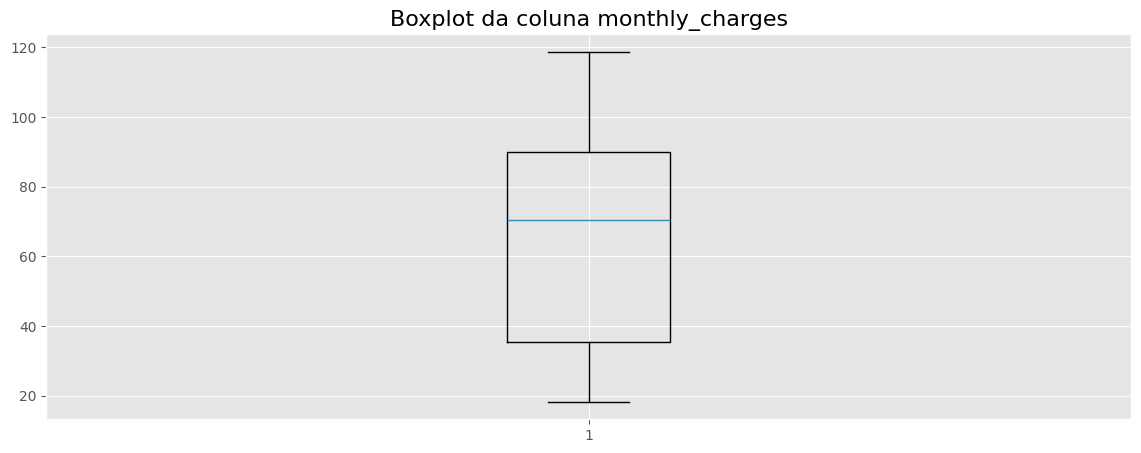

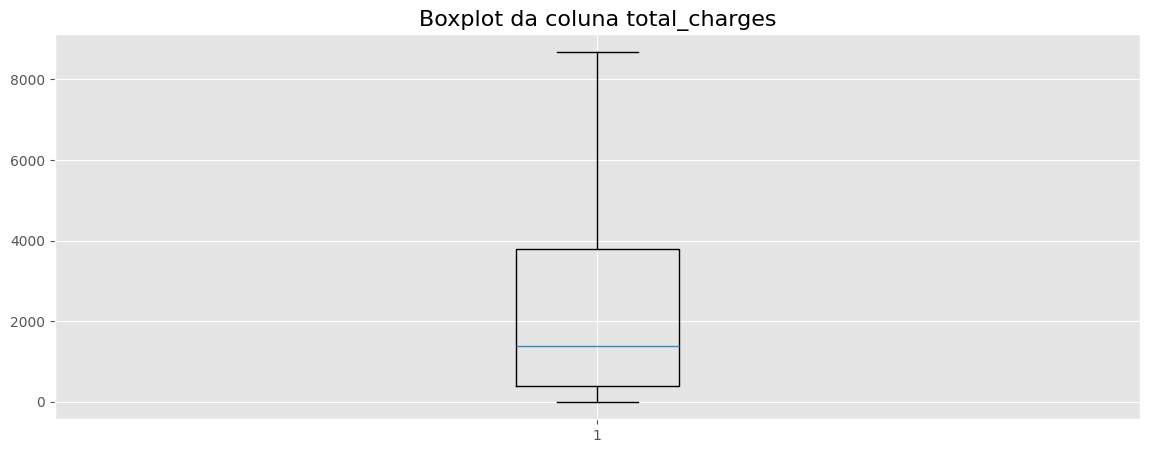

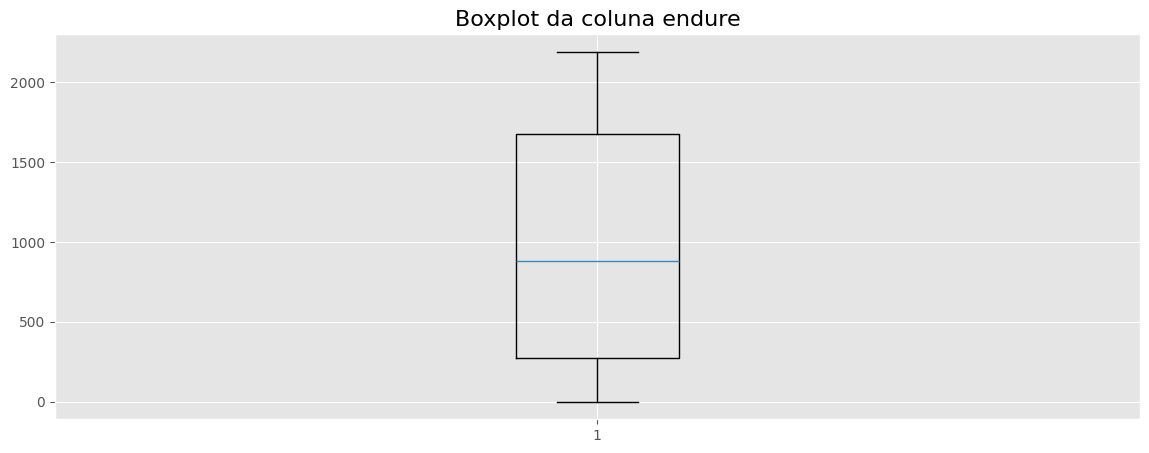

In [36]:
query_set = clean_over(df_result[['monthly_charges','total_charges','endure']], weight=0.25, show_results=True)

como o menor total esta menor que a de recargas mensais?

In [37]:
df_result.query('total_charges < monthly_charges')

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,endure,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0,0,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0,0,Male,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0,0,Male,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0,0,Male,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0,0,Female,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0,0,Male,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0,0,Female,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Aparentemente não foi contabilizado o total daqueles que sairam no ultimo mes da extração dos dados.

In [38]:
df_result = df_result.query('begin_date < "2020-01-01"').copy()
df_result.shape

(6799, 21)

Limpando onde ficou `N/A`

In [39]:
df_result['internet_service'].fillna('No Plan', inplace=True)

In [40]:
df_result['online_security'].fillna('No Plan', inplace=True)

In [41]:
df_result['online_backup'].fillna('No Plan', inplace=True)

In [42]:
df_result['device_protection'].fillna('No Plan', inplace=True)

In [43]:
df_result['tech_support'].fillna('No Plan', inplace=True)

In [44]:
df_result['streaming_tv'].fillna('No Plan', inplace=True)

In [45]:
df_result['streaming_movies'].fillna('No Plan', inplace=True)

In [46]:
df_result['multiple_lines'].fillna('No Plan', inplace=True)

In [47]:
# analise das strings pra ter certeza que não há anomalias
for col in df_result.columns[1:]:
    if df_result[col].dtype == 'object':  # Apenas para colunas categóricas
        print("uniques from",col,df_result[col].unique(),'\n')

uniques from churn ['No' 'Yes'] 

uniques from type ['One year' 'Month-to-month' 'Two year'] 

uniques from paperless_billing ['No' 'Yes'] 

uniques from payment_method ['Mailed check' 'Bank transfer (automatic)' 'Electronic check'
 'Credit card (automatic)'] 

uniques from gender ['Male' 'Female'] 

uniques from partner ['No' 'Yes'] 

uniques from dependents ['No' 'Yes'] 

uniques from internet_service ['DSL' 'Fiber optic' 'No Plan'] 

uniques from online_security ['Yes' 'No' 'No Plan'] 

uniques from online_backup ['No' 'Yes' 'No Plan'] 

uniques from device_protection ['Yes' 'No' 'No Plan'] 

uniques from tech_support ['No' 'Yes' 'No Plan'] 

uniques from streaming_tv ['No' 'Yes' 'No Plan'] 

uniques from streaming_movies ['No' 'Yes' 'No Plan'] 

uniques from multiple_lines ['No' 'No Plan' 'Yes'] 



In [48]:
# result do result
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6799 entries, 1 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        6799 non-null   object        
 1   begin_date         6799 non-null   datetime64[ns]
 2   churn              6799 non-null   object        
 3   type               6799 non-null   object        
 4   paperless_billing  6799 non-null   object        
 5   payment_method     6799 non-null   object        
 6   monthly_charges    6799 non-null   float64       
 7   total_charges      6799 non-null   float64       
 8   endure             6799 non-null   int32         
 9   gender             6799 non-null   object        
 10  senior_citizen     6799 non-null   int64         
 11  partner            6799 non-null   object        
 12  dependents         6799 non-null   object        
 13  internet_service   6799 non-null   object        
 14  online_s

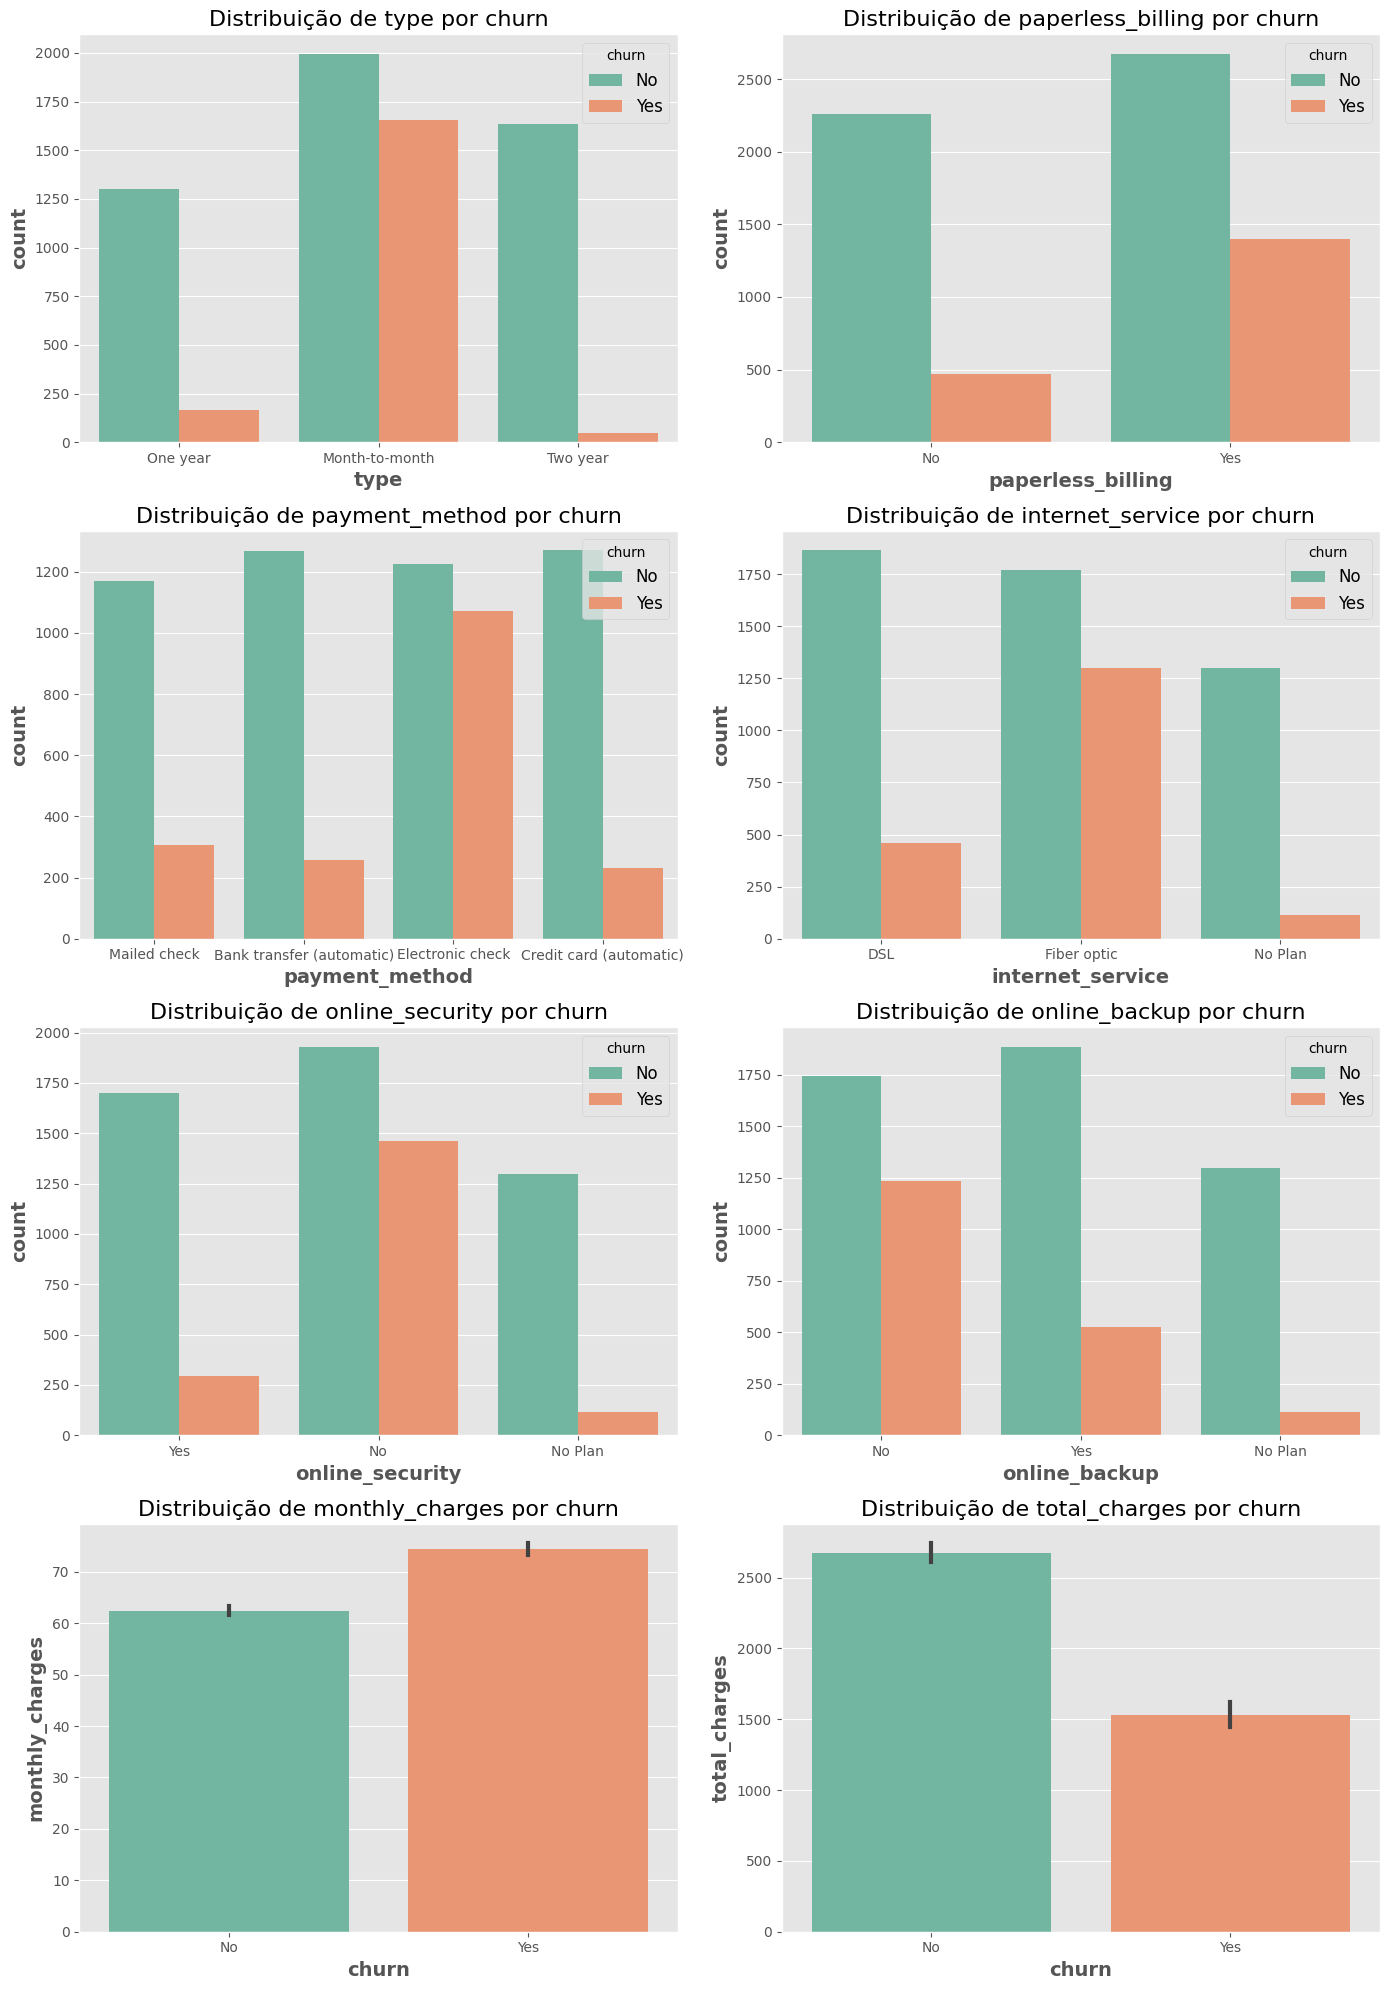

In [49]:
# Visualização das variáveis categóricas por churn
categorical_columns = ['type', 'paperless_billing', 'payment_method', 'internet_service', 
                       'online_security', 'online_backup','monthly_charges', 'total_charges']

# Criar gráficos de barras para as variáveis categóricas
plt.figure(figsize=(14, 20))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 2, i)
    if col in ['monthly_charges', 'total_charges']:
        sns.barplot(data=df_result, x='churn', y=col, hue='churn', estimator='mean', palette='Set2', legend=False)
        # group = df_result[[col, 'churn']].groupby('churn').mean()     
        # plt.pie(group[col], labels=df_result['churn'].unique())
    else:
        sns.countplot(data=df_result, x=col, hue='churn', palette='Set2')
    plt.title(f'Distribuição de {col} por churn')

plt.tight_layout()
plt.show()

Uma escolha comum dos clientes desistentes são os planos mensais pagos via check eletronico, usuarios de fibra ótica sem segurança online e nem backup



## Categorização dos dados para treino de maquina

In [50]:
label_encoder = LabelEncoder()

encoders = {}

# Aplicar LabelEncoder e armazenar os encoders
for col in df_result.columns[1:]:
    if df_result[col].dtype == 'object':  # Apenas para colunas categóricas
        le = LabelEncoder()
        df_result[col] = le.fit_transform(df_result[col])
        encoders[col] = le  # Armazenar o encoder para cada coluna


In [51]:
df_result.head(4)

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,endure,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1,5575-GNVDE,2017-04-01,0,1,0,3,56.95,1889.50,1036,1,...,0,0,0,2,0,2,0,0,0,0
2,3668-QPYBK,2019-10-01,1,0,1,3,53.85,108.15,61,1,...,0,0,0,2,2,0,0,0,0,0
3,7795-CFOCW,2016-05-01,0,1,0,0,42.30,1840.75,1371,1,...,0,0,0,2,0,2,2,0,0,1
4,9237-HQITU,2019-09-01,1,0,1,2,70.70,151.65,61,0,...,0,0,1,0,0,0,0,0,0,0


# Analise do "churn"

In [52]:
df_churned = df_result.query('churn == False')
print(f'Temos {round(df_churned.shape[0] * 100 / df_result.shape[0])}% dos perfis de clientes que não desistiram,\033[1m sendo {100-round(df_churned.shape[0] * 100 / df_result.shape[0])}% a taxa de churn.')

Temos 73% dos perfis de clientes que não desistiram, sendo 27% a taxa de churn.


In [53]:
# Dividir a variável monthly_charges em 4 buckets usando pd.qcut
df_result['monthly_charges_binned'] = pd.qcut(df_result['monthly_charges'], q=5)

# Agrupar pelos buckets e calcular a taxa de churn (média da coluna churn), observed pra evitar a mensagem de aviso
df_result.groupby('monthly_charges_binned', observed=True)['churn'].mean()*100

monthly_charges_binned
(18.249, 25.25]    10.263930
(25.25, 60.06]     26.032448
(60.06, 79.65]     32.697947
(79.65, 94.6]      36.082474
(94.6, 118.75]     32.424466
Name: churn, dtype: float64

In [54]:
# Dividir a variável total_charges em buckets usando pd.qcut
df_result['total_charges_binned'] = pd.qcut(df_result['total_charges'], q=10)

# Agrupar pelos buckets e calcular a taxa de churn (média da coluna churn), observed pra evitar a mensagem de aviso
df_result.groupby('total_charges_binned', observed=True)['churn'].mean()*100

total_charges_binned
(18.849, 130.71]      67.794118
(130.71, 331.5]       37.352941
(331.5, 639.53]       27.205882
(639.53, 1034.26]     26.029412
(1034.26, 1471.75]    23.382353
(1471.75, 2192.66]    20.324006
(2192.66, 3254.95]    27.794118
(3254.95, 4550.27]    17.500000
(4550.27, 6030.54]    15.000000
(6030.54, 8684.8]     12.500000
Name: churn, dtype: float64

In [55]:
# analise média de quanto tempo o usuario permanece antes de desistir
df_temp = df_result.copy()
df_temp['endure_binned'] = pd.qcut(df_temp['total_charges'], q=8)
print(df_temp.groupby('endure_binned', observed=True)['churn'].mean()*100)

endure_binned
(18.849, 170.975]      62.941176
(170.975, 471.45]      32.823529
(471.45, 929.225]      27.176471
(929.225, 1471.75]     22.470588
(1471.75, 2426.675]    22.025913
(2426.675, 3901.85]    22.941176
(3901.85, 5674.275]    17.058824
(5674.275, 8684.8]     12.470588
Name: churn, dtype: float64


In [56]:
print(df_temp.query('churn == 1')['endure'].mean().round().astype(int))
del df_temp

547


##### cerca de 63% dos usuarios que sofreram churn permaneceram por 19 a 170 dias, contudo a média global é de 547 dias

In [57]:
# encode resultantes
label_encoder = LabelEncoder()
df_result['monthly_charges_binned'] = label_encoder.fit_transform(df_result['monthly_charges_binned'])
df_result['total_charges_binned'] = label_encoder.fit_transform(df_result['total_charges_binned'])

In [58]:
df_result.head()

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,endure,gender,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,monthly_charges_binned,total_charges_binned
1,5575-GNVDE,2017-04-01,0,1,0,3,56.95,1889.50,1036,1,...,0,2,0,2,0,0,0,0,1,5
2,3668-QPYBK,2019-10-01,1,0,1,3,53.85,108.15,61,1,...,0,2,2,0,0,0,0,0,1,0
3,7795-CFOCW,2016-05-01,0,1,0,0,42.30,1840.75,1371,1,...,0,2,0,2,2,0,0,1,1,5
4,9237-HQITU,2019-09-01,1,0,1,2,70.70,151.65,61,0,...,1,0,0,0,0,0,0,0,2,1
5,9305-CDSKC,2019-03-01,1,0,1,2,99.65,820.50,245,0,...,1,0,0,2,0,2,2,2,4,3


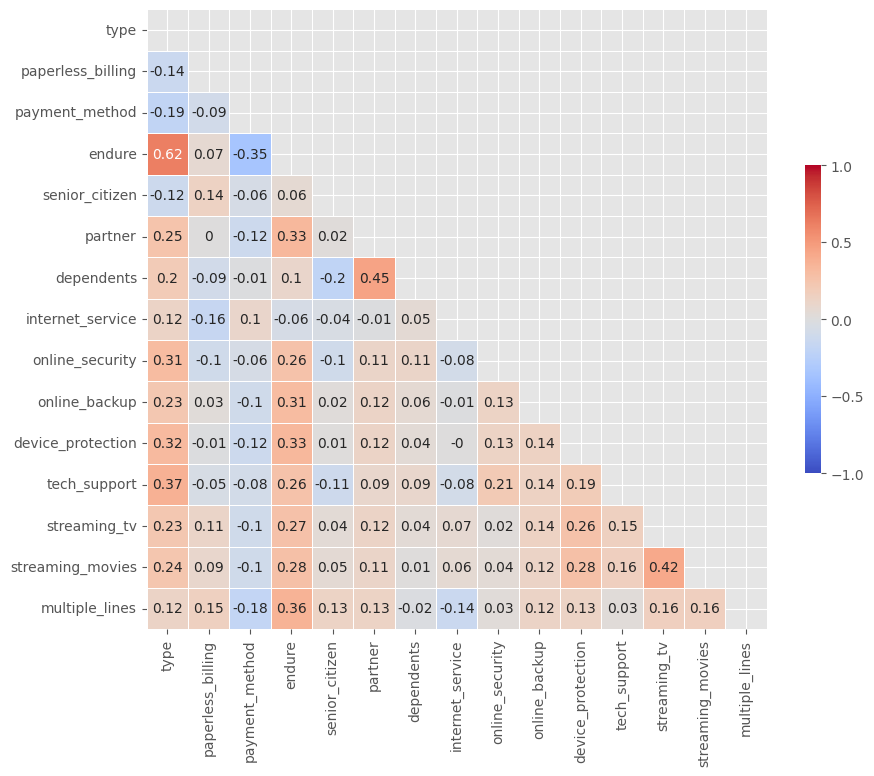

In [59]:
# correlação das colunas
corr = df_churned.drop(['customer_id','begin_date','gender','churn','monthly_charges','total_charges'], axis=1).corr(numeric_only=True).round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 10)) 
heatmap = sns.heatmap(corr, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      )
# Add o nome das colunas
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True});

Uma alta correlação entre o tipo de pagamento e o tempo de permanencia do cliente

Outra correlação não muito importante está nos streamings e quem tem dependentes com quem tem parceiros

# Previsões

In [60]:
df = df_result.drop(['customer_id','gender','begin_date','monthly_charges','total_charges'], axis=1) # removendo a coluna de gender tambem pois ela possuiu pouca correlação com qualquer dado

features, validation = train_test_split(df, random_state=12, test_size=0.3)
test, valid = train_test_split(validation, test_size=0.2)
features_train=features.drop('churn',axis=1)
target_train=features['churn']

features_test=test.drop('churn',axis=1)
target_test=test['churn']

features_valid=valid.drop('churn',axis=1)
target_valid=valid['churn']

In [61]:
df_predictions = pd.DataFrame()
df_predictions['target'] = target_valid

### RandomForestClassifier 

Melhores hiperparâmetros encontrados: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 150}
 Acurácia: 0.7873774509803921
 F1-Score: 0.6865401987353207
 ROC AUC: 0.8849397711541592
Tempo total de execução: 2.90 segundos


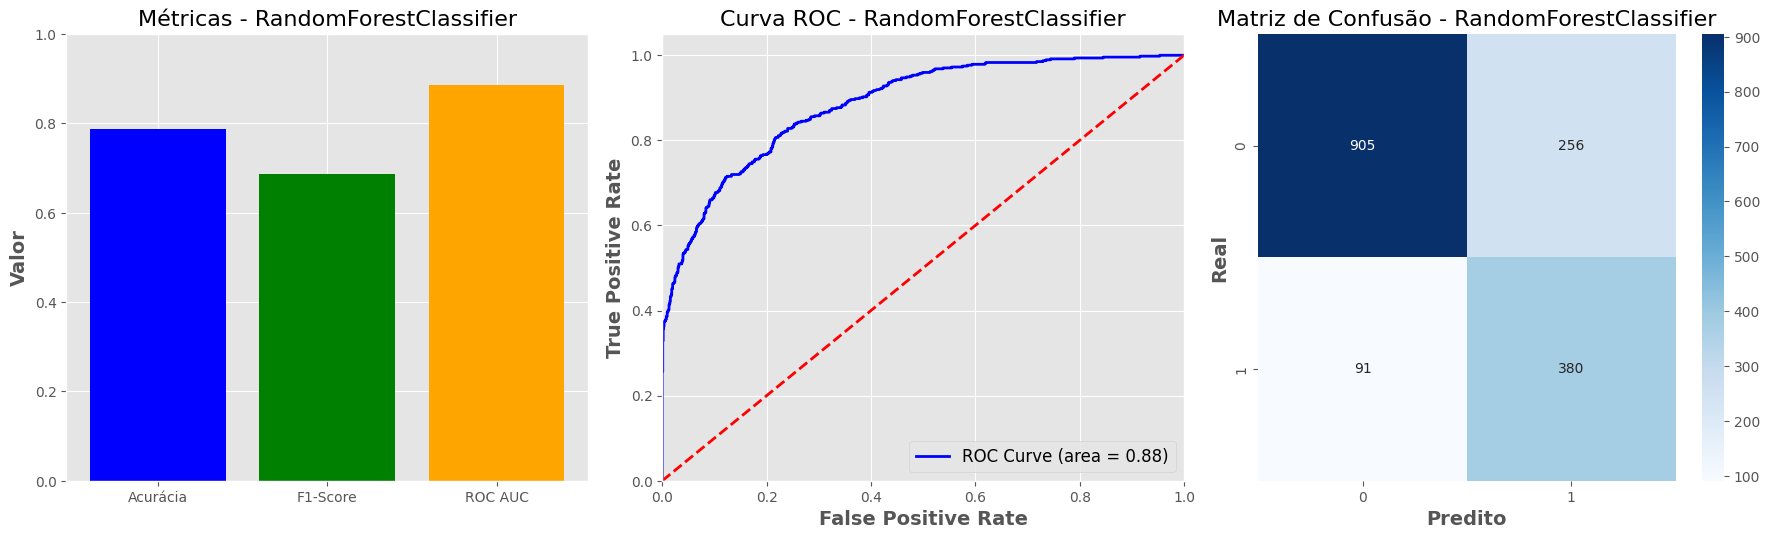

In [62]:
# grid de hiperparâmetros para buscar
param_grid = {
    'n_estimators': [150,],
    'max_depth': [10,],
    'min_samples_split': [2,],
    'min_samples_leaf': [16,],
    'max_features': ['sqrt', ],
    'bootstrap': [True, ],
    'class_weight':['balanced'],
}

# Inicializar o modelo RandomForestClassifier
rfc = RandomForestClassifier(random_state=12345)

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv=7, n_jobs=-1, verbose=0)

# tempo de início
start_time = time.time()

# Realizar o treinamento com GridSearchCV
grid_search.fit(features_train, target_train)

# Calcular o tempo total de execução
end_time = time.time()
time_lapse = end_time - start_time

best_model = grid_search.best_estimator_ # Melhor modelo obtido

print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

# Adicionar o melhor modelo ao ranking
ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)
# Prever usando o melhor modelo
df_predictions['RDC'] = best_model.predict(features_valid)

### DecisionTreeClassifier

Fitting 2 folds for each of 1008 candidates, totalling 2016 fits
Melhores hiperparâmetros encontrados: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 27, 'min_samples_split': 2, 'splitter': 'random'}
 Acurácia: 0.8308823529411765
 F1-Score: 0.6617647058823529
 ROC AUC: 0.873140878991864
Tempo total de execução: 3.40 segundos


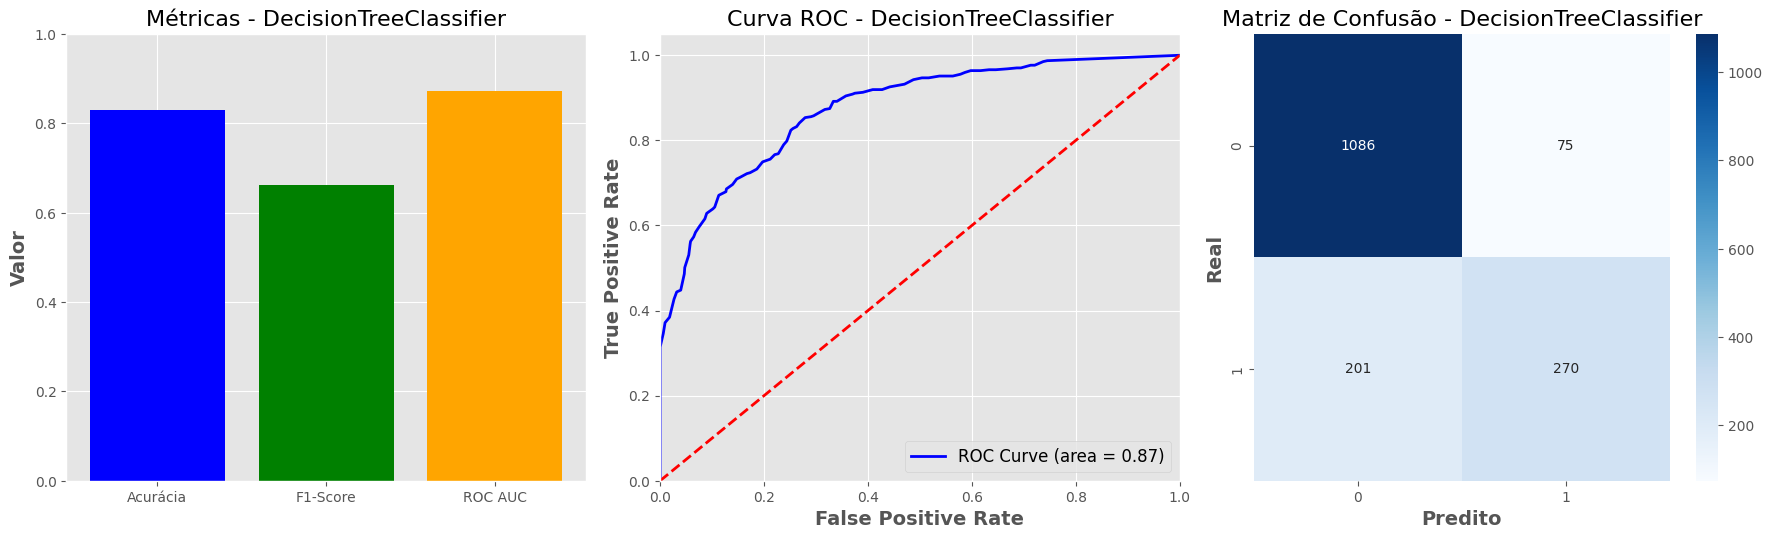

In [63]:
# Tempo de início
start_time = time.time()

# Grid de hiperparâmetros para DecisionTreeClassifier
param_grid = {
    'max_depth': [None,5, 10, 20],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [ 18, 22,24,25,26,27,28],  # Número mínimo de amostras em um nó folha
    'max_features': [None, 'sqrt', 'log2'],  # Número de recursos a serem considerados ao procurar o melhor split
    'criterion': ['gini', 'entropy'],  # Função para medir a qualidade da divisão
    'splitter': ['best', 'random']  # Estratégia usada para escolher a divisão no nó
}
# Inicializar o modelo
dtc = DecisionTreeClassifier(random_state=42)

# Configurar o e treinar o modelo usando o GridSearchCV pra variar os testes
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='roc_auc', cv=2, n_jobs=-1, verbose=1).fit(features_train, target_train)

# Calcular o tempo total de execução
end_time = time.time()
time_lapse = end_time - start_time

# Melhor modelo obtido
best_model = grid_search.best_estimator_
# Previsões com o melhor modelo
best_predictions = best_model.predict(features_test)
# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

# Adicionar o melhor modelo ao ranking
ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)

# Prever usando o melhor modelo no DataFrame original
df_predictions['DTC'] = best_model.predict(features_valid)


### LightGBM 

[LightGBM] [Info] Number of positive: 1282, number of negative: 3477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 4759, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269384 -> initscore=-0.997748
[LightGBM] [Info] Start training from score -0.997748
Melhores hiperparâmetros encontrados: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
 Acurácia: 0.8915441176470589
 F1-Score: 0.7949015063731171
 ROC AUC: 0.9331447924495868
Tempo total de execução: 10.77 segundos


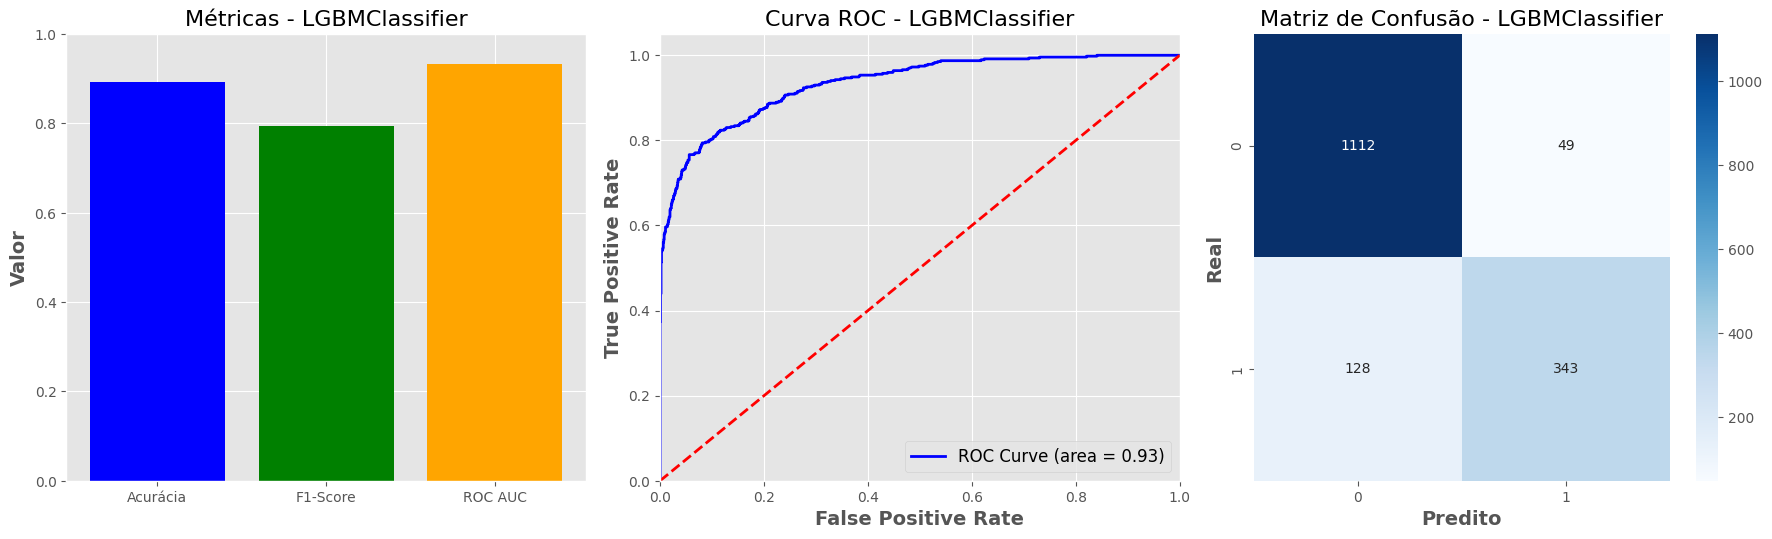

In [64]:
# Tempo de início
start_time = time.time()
# Treinando um modelo de classificação com LightGBM
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 10],
    'boosting_type': ['gbdt', 'dart'],
}

# Inicializar o modelo LGBMClassifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Configurar o GridSearchCV com o LGBMClassifier
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)

# Tempo de início
start_time = time.time()

# Realizar o treinamento com GridSearchCV
grid_search.fit(features_train, target_train)

# Calcular o tempo total de execução
end_time = time.time()
time_lapse = end_time - start_time

# Melhor modelo obtido
best_model_lgbm = grid_search.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

ranking.add_model(best_model_lgbm, target_test, features_test, time_lapse=time_lapse)

df_predictions['LightGBM'] = best_model_lgbm.predict(features_valid)


 99%|===================| 4703/4759 [00:25<00:00]        

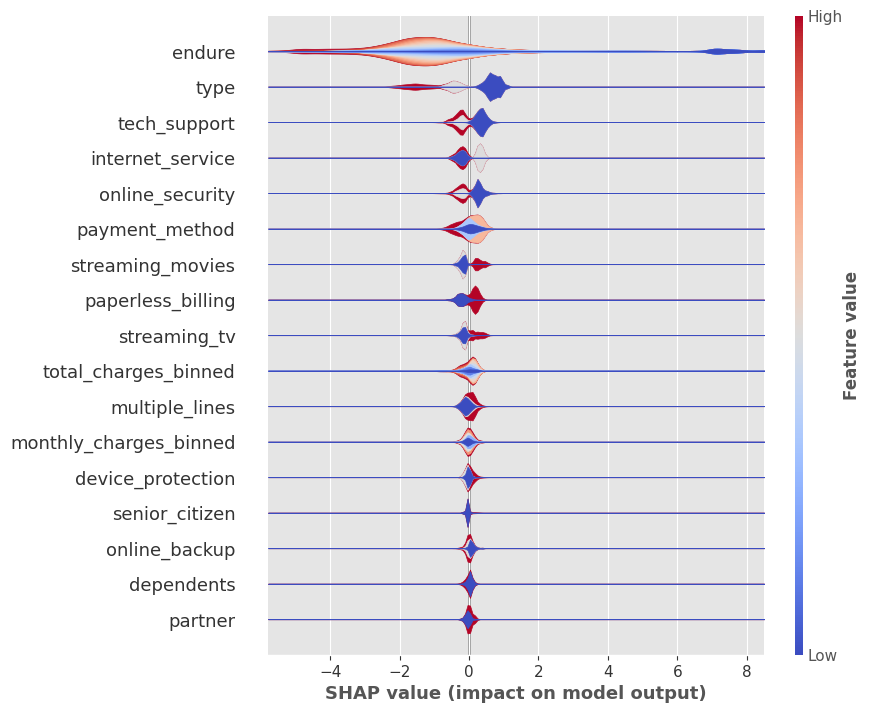

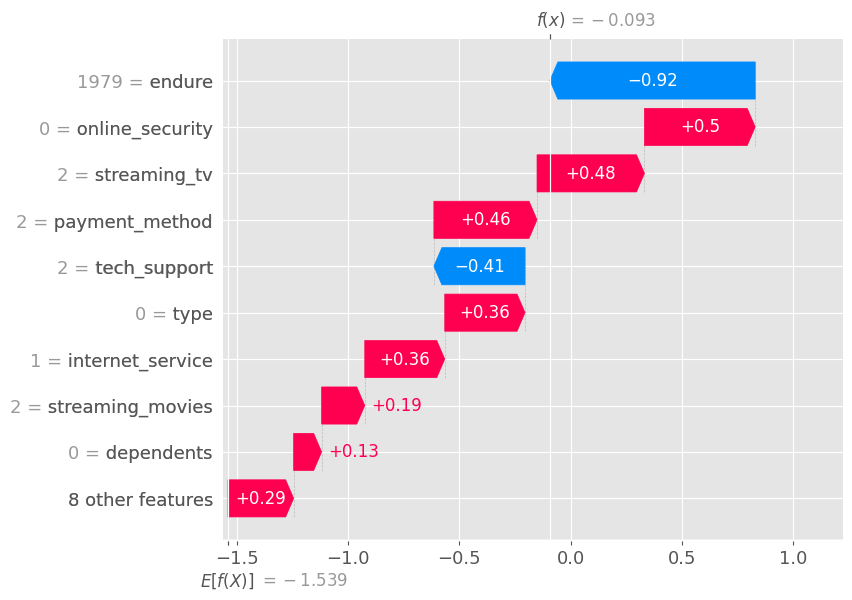

In [65]:
shap.initjs()
explainer = shap.Explainer(best_model_lgbm, features_train) # explainer
shap_values = explainer(features_train) # Calcular os valores SHAP
shap.plots.violin(shap_values, features=features_train, feature_names=list(features_train.columns), plot_type="layered_violin") # Plotar a importância global das variáveis
shap.plots.waterfall(shap_values[0]) # Plotar a explicação para uma previsão individual

### LogisticRegression

Tempo total de execução: 0.02 segundos
 Acurácia: 0.8131127450980392
 F1-Score: 0.6415981198589894
 ROC AUC: 0.8552011498982318
Tempo total de execução: 0.02 segundos


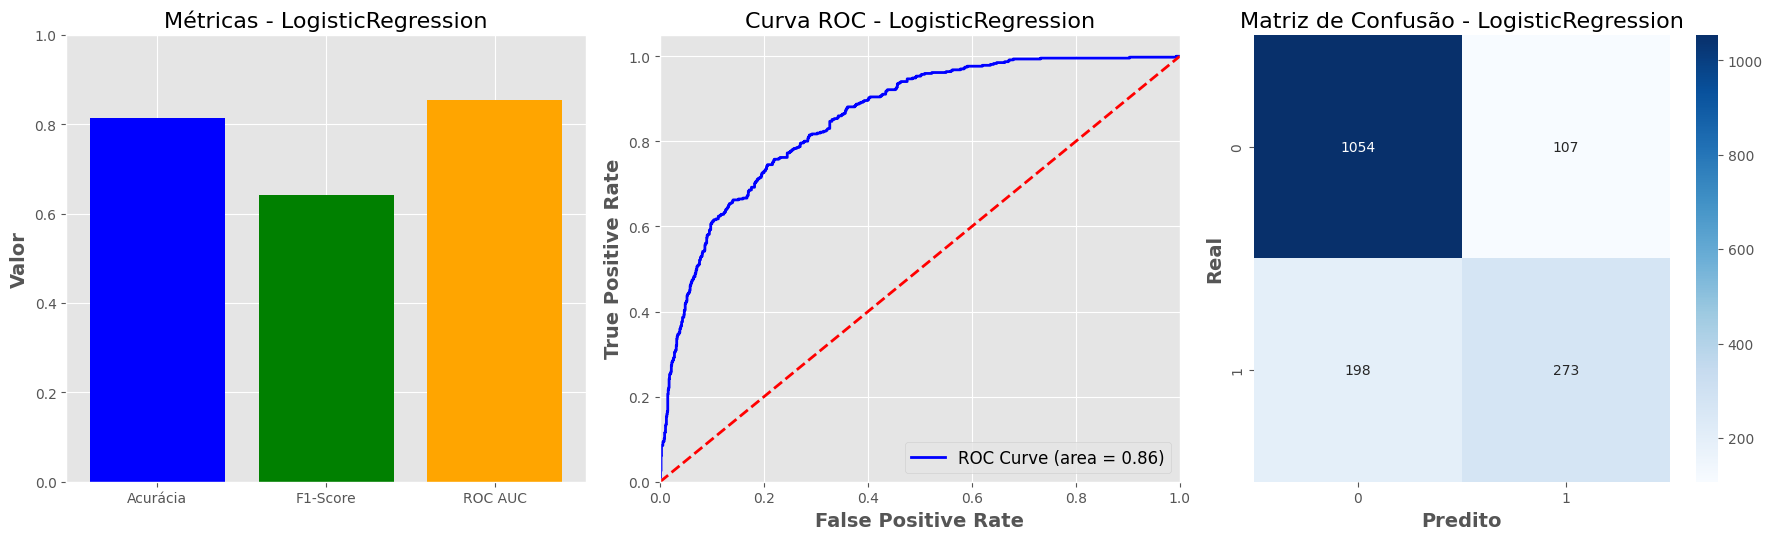

In [66]:
# Iniciar a medição do tempo
start_time = time.time()

# Definir o modelo LogisticRegression com hiperparâmetros otimizados
lr = LogisticRegression(max_iter=8000, solver='liblinear', penalty='l2', C=5, random_state=12345)

# Treinar o modelo
lr.fit(features_train, target_train)

# Avaliação do modelo
predictions = lr.predict(features_test)

# Medir o tempo de execução
end_time = time.time()
time_lapse = end_time - start_time

# Exibir o tempo de execução
print(f"Tempo total de execução: {time_lapse:.2f} segundos")
# Adicionar o modelo ao ranking com as previsões e o tempo de execução
ranking.add_model(lr, target_test, features_test, time_lapse=time_lapse)

# Fazer previsões no DataFrame original (df) para a coluna 'LR'
df_predictions['LR'] = lr.predict(features_valid)

### KNN

Melhores hiperparâmetros encontrados: {'algorithm': 'auto', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
Melhor ROC AUC nos dados de validação: 0.8424
 Acurácia: 0.8443627450980392
 F1-Score: 0.6675392670157068
 ROC AUC: 0.8736273181293672
Tempo total de execução: 9.14 segundos


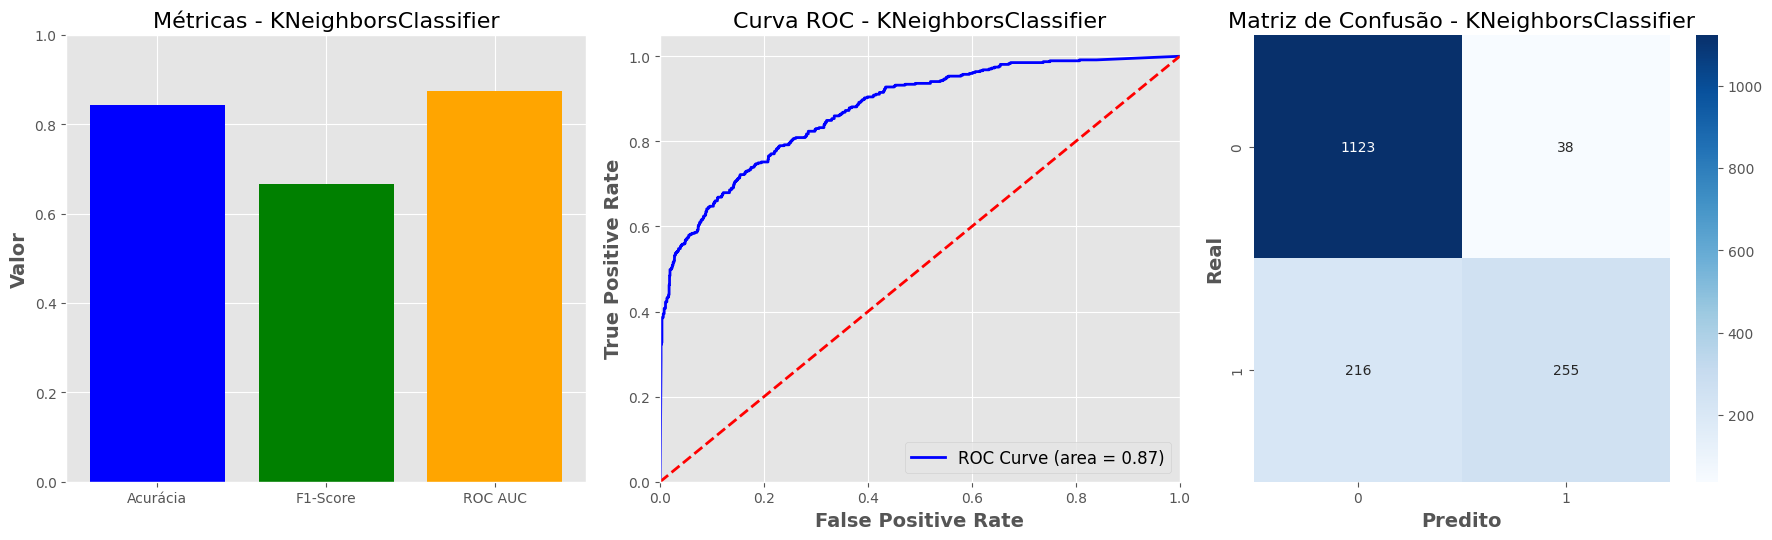

In [67]:
start_time = time.time() # Medir o tempo de início

param_grid = {
    'n_neighbors': [40,50,60],
    'weights': ['distance',],
    'algorithm': ['auto', 'kd_tree'],
    'leaf_size': [2,4,6],
    'p': [1, 2,4],
    'metric': ['minkowski',],
    'metric_params': [None], 
    'n_jobs': [-1, 1], 
}

# Inicializar o modelo KNeighborsClassifier
knn = KNeighborsClassifier()

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='roc_auc', cv=2, n_jobs=-1, verbose=0)

# Treinar o modelo usando GridSearchCV
grid_search.fit(features_train, target_train)

# Medir o tempo de fim
end_time = time.time()
time_lapse = end_time - start_time

# Melhor modelo e parâmetros encontrados
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Melhores hiperparâmetros encontrados: {best_params}")
print(f"Melhor ROC AUC nos dados de validação: {best_score:.4f}")

# Adicionar o modelo ao ranking
ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)

# Fazer previsões no DataFrame original (df)
df_predictions['KNN'] = best_model.predict(features_valid)

### CatBoostClassifier

 Acurácia: 0.8376225490196079
 F1-Score: 0.6658259773013872
 ROC AUC: 0.8853073435851295
Tempo total de execução: 0.21 segundos


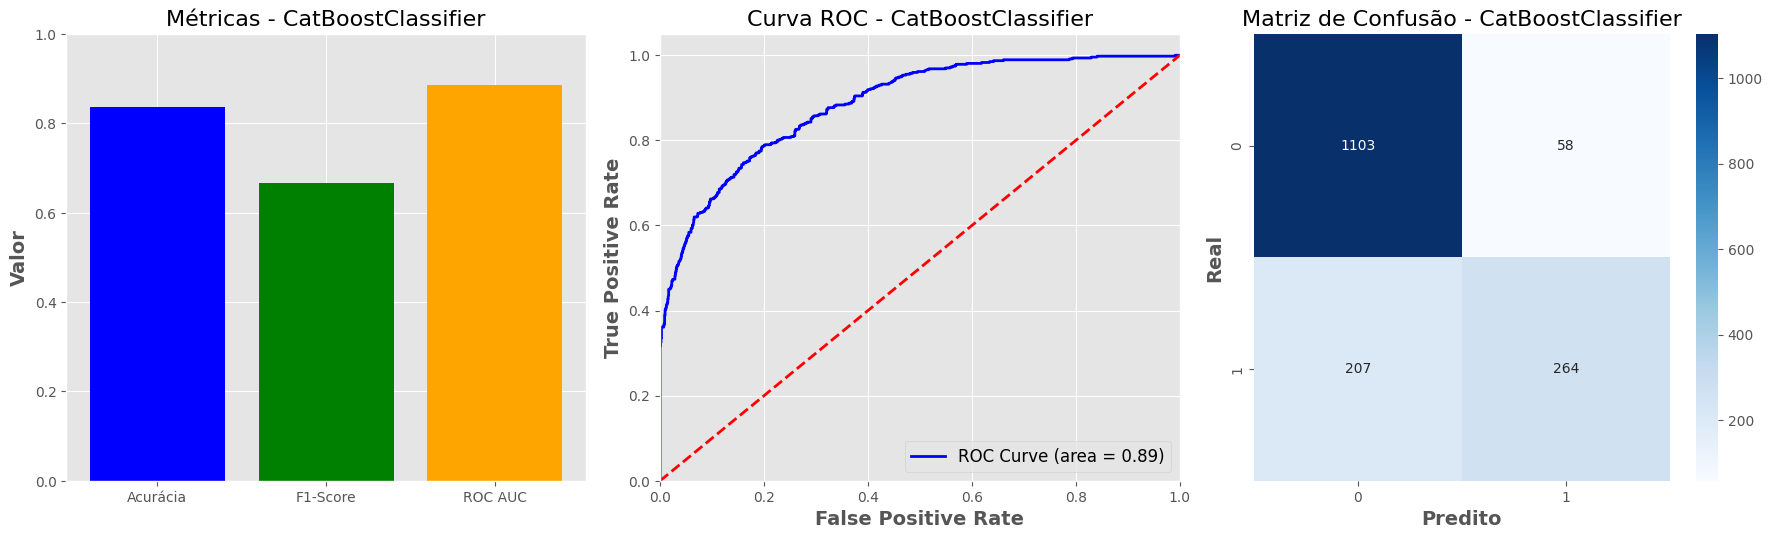

In [68]:
start_time = time.time()
# inicio e treino do modelo
catboost  = CatBoostClassifier(iterations=60, learning_rate=0.09, depth=3, verbose=0).fit(features_train, target_train)

end_time = time.time()
time_lapse = end_time - start_time
# Avaliar o modelo
ranking.add_model(catboost, target_test, features_test, time_lapse=time_lapse)
df_predictions['CBC'] = catboost.predict(features_valid)

#explainer = shap.Explainer(catboost, features_train) # explainer
#shap_values = explainer(features_train) # Calcular os valores SHAP
#shap.plots.waterfall(shap_values[0]) # Plotar a explicação para uma previsão individual
#shap.summary_plot(shap_values, features_train) # Plotar a importância global das variáveis

# Resultados dos modelos

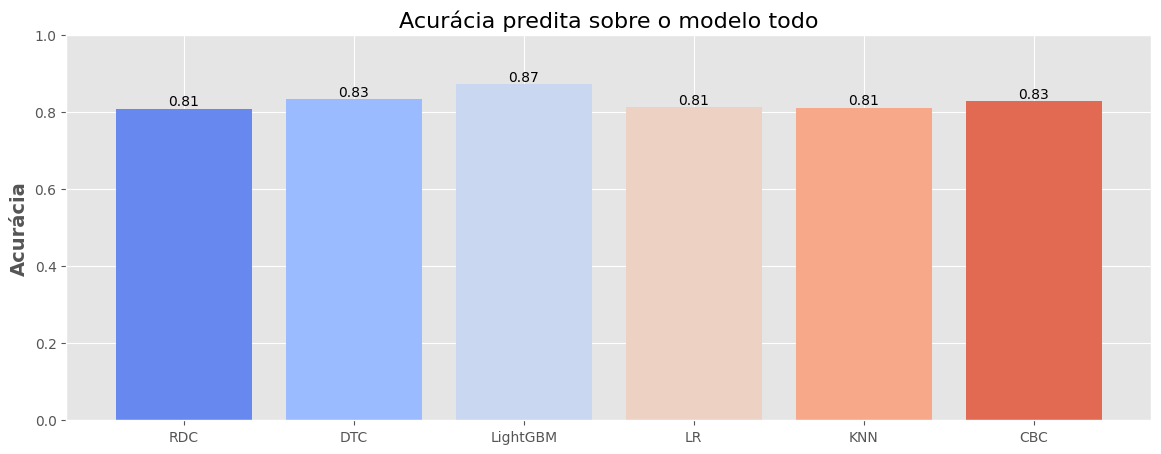

In [69]:
# Organizar os resultados em um dicionário
accuracy_dict = {}
for column in df_predictions.columns:
    if column != 'target':
        accuracy_dict[column] = (df_predictions['target'] == df_predictions[column]).mean()
        
# Plotar os valores de proximidade do target (accuracy)
plt.figure(figsize=(14, 5))
bars = plt.bar(accuracy_dict.keys(), accuracy_dict.values(), color=sns.color_palette("coolwarm", len(service_counts)))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

plt.title('Acurácia predita sobre o modelo todo')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [70]:
# ranking de melhor modelo por ROC_AUC
ranking.get_ranking(sort_by="ROC_AUC")

,Acurácia,F1-Score,ROC_AUC,Tempo_de_execução
LGBMClassifier,89.15,79.49,93.31,10.772996
CatBoostClassifier,83.76,66.58,88.53,0.206239
RandomForestClassifier,78.74,68.65,88.49,2.904036
KNeighborsClassifier,84.44,66.75,87.36,9.135579
DecisionTreeClassifier,83.09,66.18,87.31,3.399088
LogisticRegression,81.31,64.16,85.52,0.017997


# Conclusão
##### Remover os meses mais recentes da coleta de dados resultou em uma melhora significativa nos modelos, pois esses dados eram superficiais e não seriam úteis para determinar a condição de desistência dos usuários.

##### As variáveis mais impactantes para o nosso melhor modelo foram o tempo de permanência do usuário, o tipo de recarga, e as relações com os planos de internet.

##### Durante a análise de inconsistência dos dados, não foram encontrados outliers nas colunas numéricas, mesmo com uma margem de 25%. Na análise exploratória de dados (EDA), foi identificado que uma escolha comum entre os clientes desistentes são os planos mensais pagos via cheque eletrônico, além de usuários de fibra ótica que não utilizam pacotes de segurança online nem backup.

##### Considerando que a proporção de usuários que sofreram churn é menor em comparação com os que não sofreram, foi bastante significativa a constatação de que muitos dos que desistiram compartilham características como pagamento mensal digital (sem papel). Outras características desse grupo incluem o uso de internet de fibra ótica sem pacote de segurança online ou backup.

##### Além disso, cerca de 63% dos usuários que sofreram churn permaneceram no serviço por um período entre 19 e 170 dias, embora a média global de permanência seja de 547 dias.

##### O modelo baseado em LightGBM alcançou 93,5% na métrica de ROC AUC e uma acurácia de 89%, superando os demais modelos com apenas 9 segundos de treinamento em um dataframe de quase 7 mil linhas.

##### Com isso, desenvolvemos um modelo capaz de prever se um usuário sofrerá churn. O próximo passo é criar um modelo para prever em quanto tempo o usuário provavelmente desistirá.

##### A taxa de churn é de 27%, e uma característica importante dos desistentes foi o pagamento mensal, observado principalmente entre aqueles que pagavam entre 79,65 e 94,60 dollars.